In [1]:
library(tidyverse)
library(haven)      # For reading .dta files
library(fixest)     # For high-dimensional fixed effects (Gravity standard)
library(sandwich)   # For robust standard errors
library(lmtest)     # For testing

dots <- read_dta("dots1960_2005.dta") # Trade flows (every 5 years)
pwt  <- read_dta("pwt.dta")           # GDP and Pop
rta  <- read_dta("RTA.dta")           # Regional Trade Agreements
cu   <- read_dta("CU.dta")            # Currency Unions
dist <- read_dta("dist_cepii.dta")    # Distance & Geo variables

# 1. Prepare PWT (Economic Mass)
# We need to create two copies: one for Origin (o) and one for Destination (d)
pwt_o <- pwt %>%
  select(iso_o = iso3, year, gdp_o = cgdp, pop_o = pop)

pwt_d <- pwt %>%
  select(iso_d = iso3, year, gdp_d = cgdp, pop_d = pop)

# 2. Merge Data
gravity_df <- dots %>%
  rename(trade = flow_dots) %>%
  # Merge Origin GDP/Pop
  left_join(pwt_o, by = c("iso_o", "year")) %>%
  # Merge Destination GDP/Pop
  left_join(pwt_d, by = c("iso_d", "year")) %>%
  # Merge RTA (Time varying)
  left_join(rta, by = c("iso_o", "iso_d", "year")) %>%
  # Merge Currency Union (Time varying)
  left_join(cu %>% rename(cu = comcur), by = c("iso_o", "iso_d", "year")) %>%
  # Merge Distance/Geo (Time invariant) - Note: dist usually doesn't have year
  left_join(dist, by = c("iso_o", "iso_d"))

# 3. Cleaning & Transformations
gravity_clean <- gravity_df %>%
  # Replace NAs in binary variables with 0 (Crucial for RTA/CU)
  mutate(
    rta = replace_na(rta, 0),
    cu  = replace_na(cu, 0),
    # Log transformations
    ln_trade = log(trade),
    ln_gdp_o = log(gdp_o),
    ln_gdp_d = log(gdp_d),
    ln_dist  = log(dist), # Using simple distance, though distw is better theoretically
    ln_pop_o = log(pop_o),
    ln_pop_d = log(pop_d)
  ) %>%
  # Filter out zero/NA trade and missing GDPs for log-linear model
  filter(trade > 0, !is.na(gdp_o), !is.na(gdp_d), !is.na(dist))

# Summary
cat("Number of Observations:", nrow(gravity_clean))
cat("\nNumber of Pairs:", n_distinct(paste(gravity_clean$iso_o, gravity_clean$iso_d)))

summary_stats <- gravity_clean %>%
    group_by(year) %>%
    summarise(
        mean_trade = mean(trade, na.rm = TRUE),
        median_trade = median(trade, na.rm = TRUE),
        mean_cu = mean(cu, na.rm = TRUE),
        mean_rta = mean(rta, na.rm = TRUE),
        share_rta = mean(rta, na.rm = TRUE) * 100,
        share_cu = mean(cu, na.rm = TRUE) * 100,
        trade_share_rta = sum(trade * rta, na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100,
        trade_share_cu = sum(trade * cu, na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100
  )
print(summary_stats)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




Number of Observations: 102018
Number of Pairs: 22124# A tibble: 10 × 9
    year  mean_trade median_trade mean_cu mean_rta share_rta share_cu
   <dbl>       <dbl>        <dbl>   <dbl>    <dbl>     <dbl>    <dbl>
 1  1960   25127636.      2000000 0.0325    0.0173      1.73    3.25 
 2  1965  270489417.      2100000 0.0395    0.0257      2.57    3.95 
 3  1970  264733538.      1430000 0.0243    0.0187      1.87    2.43 
 4  1975  471639751.      2650000 0.0180    0.0297      2.97    1.80 
 5  1980  888881412.      4570000 0.0155    0.0348      3.48    1.55 
 6  1985  993730381.      3900000 0.0146    0.0352      3.52    1.46 
 7  1990 1309485966.      4460000 0.0115    0.0367      3.67    1.15 
 8  1995 1271889876.      3790000 0.00982   0.0686      6.86    0.982
 9  2000 1259710225.      2920000 0.0141    0.0710      7.10    1.41 
10  2005 1750062408.      4480000 0.0146    0.126      12.6     1.46 
# ℹ 2 more variables: trade_share_rta <dbl>, trade_share_cu <dbl>



=========== 问题d：RTA和CU演变 ===========
# A tibble: 10 × 7
    year share_cu_pairs share_rta_pairs share_cu_trade share_rta_trade
   <dbl>          <dbl>           <dbl>          <dbl>           <dbl>
 1  1960        0.0325           0.0173        0.0766           0.0949
 2  1965        0.0395           0.0257        0.00512          0.159 
 3  1970        0.0243           0.0187        0.00255          0.240 
 4  1975        0.0180           0.0297        0.00251          0.259 
 5  1980        0.0155           0.0348        0.00142          0.274 
 6  1985        0.0146           0.0352        0.00115          0.197 
 7  1990        0.0115           0.0367        0.00111          0.310 
 8  1995        0.00982          0.0686        0.00165          0.537 
 9  2000        0.0141           0.0710        0.0223           0.533 
10  2005        0.0146           0.126         0.0250           0.547 
# ℹ 2 more variables: n_countries_cu <int>, n_countries_rta <int>


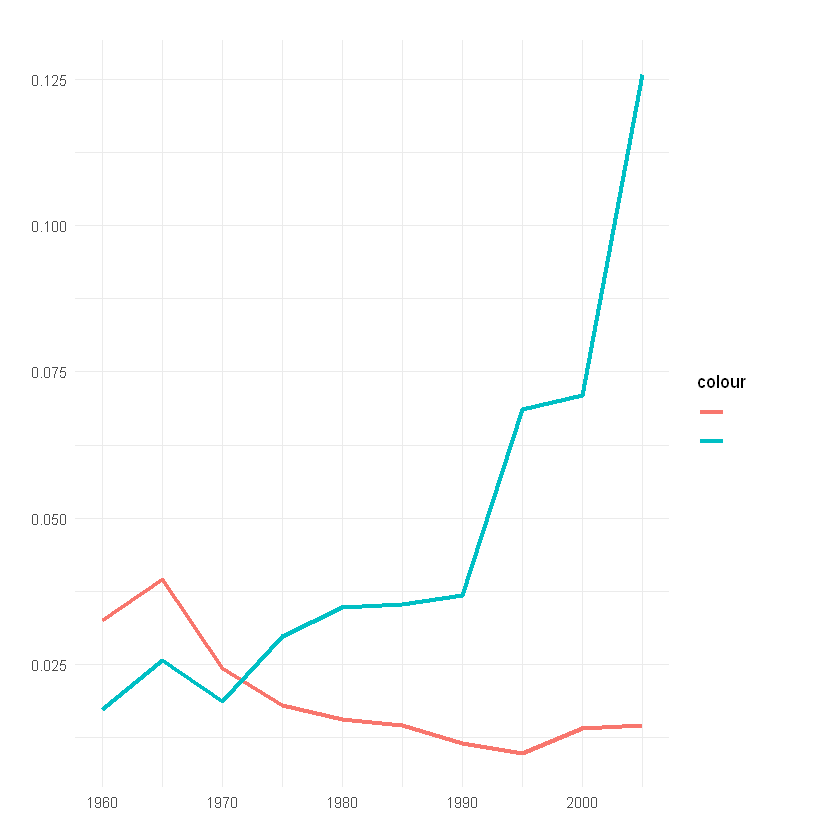

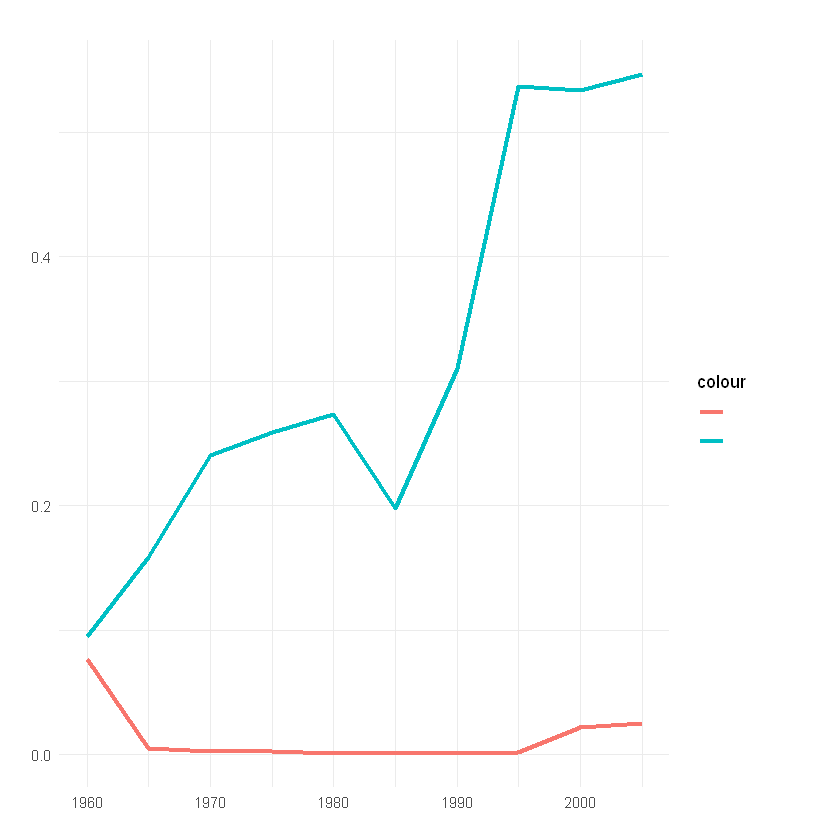

In [21]:
# 问题d：RTA和CU份额的演变
# ============================================================================

cat("\n=========== 问题d：RTA和CU演变 ===========\n")

# 计算每年RTA和CU的份额
evolution <- gravity_clean %>%
  group_by(year) %>%
  summarise(
    # 配对份额
    share_cu_pairs = mean(cu, na.rm = TRUE),
    share_rta_pairs = mean(rta, na.rm = TRUE),
    # 贸易加权份额
    share_cu_trade = sum(trade[cu == 1], na.rm = TRUE) / sum(trade, na.rm = TRUE),
    share_rta_trade = sum(trade[rta == 1], na.rm = TRUE) / sum(trade, na.rm = TRUE),
    # 参与国家数（至少在一个配对中）
    n_countries_cu = n_distinct(c(iso_o[cu == 1], iso_d[cu == 1])),
    n_countries_rta = n_distinct(c(iso_o[rta == 1], iso_d[rta == 1]))
  )

print(evolution)

# 可视化
library(ggplot2)
p1 <- ggplot(evolution, aes(x = year)) +
  geom_line(aes(y = share_cu_pairs, color = "CU配对份额"), linewidth = 1.2) +
  geom_line(aes(y = share_rta_pairs, color = "RTA配对份额"), linewidth = 1.2) +
  labs(title = "RTA和CU的配对份额演变",
       y = "份额", x = "年份") +
  theme_minimal()

p2 <- ggplot(evolution, aes(x = year)) +
  geom_line(aes(y = share_cu_trade, color = "CU贸易份额"), linewidth = 1.2) +
  geom_line(aes(y = share_rta_trade, color = "RTA贸易份额"), linewidth = 1.2) +
  labs(title = "RTA和CU的贸易加权份额演变",
       y = "份额", x = "年份") +
  theme_minimal()

print(p1)
print(p2)


In [2]:
# ============================================================================
# Question d: Evolution of RTA and CU Shares
# ============================================================================

cat("\n=========== Question d: Evolution of RTA and CU Shares ===========\n")

evolution_summary <- gravity_clean %>%
  group_by(year) %>%
  summarise(
    # Pair shares
    share_cu_pairs = mean(cu, na.rm = TRUE) * 100,
    share_rta_pairs = mean(rta, na.rm = TRUE) * 100,
    # Trade-weighted shares
    share_cu_trade = sum(trade[cu == 1], na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100,
    share_rta_trade = sum(trade[rta == 1], na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100,
    # Number of participating countries
    n_countries_cu = n_distinct(c(iso_o[cu == 1], iso_d[cu == 1])),
    n_countries_rta = n_distinct(c(iso_o[rta == 1], iso_d[rta == 1]))
  )

print(evolution_summary)


=========== Question d: Evolution of RTA and CU Shares ===========
# A tibble: 10 × 7
    year share_cu_pairs share_rta_pairs share_cu_trade share_rta_trade
   <dbl>          <dbl>           <dbl>          <dbl>           <dbl>
 1  1960          3.25             1.73          7.66             9.49
 2  1965          3.95             2.57          0.512           15.9 
 3  1970          2.43             1.87          0.255           24.0 
 4  1975          1.80             2.97          0.251           25.9 
 5  1980          1.55             3.48          0.142           27.4 
 6  1985          1.46             3.52          0.115           19.7 
 7  1990          1.15             3.67          0.111           31.0 
 8  1995          0.982            6.86          0.165           53.7 
 9  2000          1.41             7.10          2.23            53.3 
10  2005          1.46            12.6           2.50            54.7 
# ℹ 2 more variables: n_countries_cu <int>, n_countries_rta <

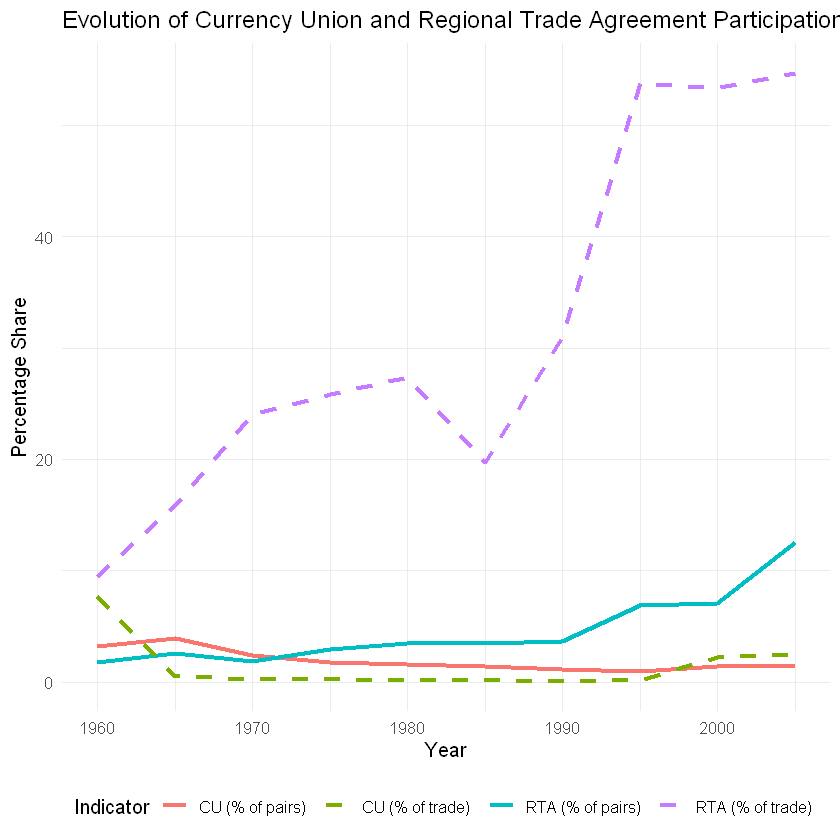

In [3]:
# Visualization
p_evolution <- ggplot(evolution_summary, aes(x = year)) +
  geom_line(aes(y = share_cu_pairs, color = "CU (% of pairs)"), linewidth = 1.2) +
  geom_line(aes(y = share_rta_pairs, color = "RTA (% of pairs)"), linewidth = 1.2) +
  geom_line(aes(y = share_cu_trade, color = "CU (% of trade)"), linewidth = 1.2, linetype = "dashed") +
  geom_line(aes(y = share_rta_trade, color = "RTA (% of trade)"), linewidth = 1.2, linetype = "dashed") +
  labs(title = "Evolution of Currency Union and Regional Trade Agreement Participation",
       y = "Percentage Share", x = "Year",
       color = "Indicator") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom")

print(p_evolution)

In [4]:
# ======================
# GRAVITY ESTIMATIONS (Question e)
# ======================

# (a) Traditional Gravity (GDP + Dist)
reg_a <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist | year, 
               data = gravity_clean, cluster = ~iso_o + iso_d)

# (b) Adding CU and RTA
reg_b <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + cu + rta | year, 
               data = gravity_clean, cluster = ~iso_o + iso_d)

# (c) Adding Historical Ties (Language, Colony)
reg_c <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + cu + rta + 
               comlang_off + colony | year, 
               data = gravity_clean, cluster = ~iso_o + iso_d)

# (e) Importer and Exporter Fixed Effects (The "Anderson-van Wincoop" Approximation)
# Note: Variables specific to a country (GDP) are perfectly collinear with Country FEs 
# if we use Year*Country FEs. If we use simple Country FEs, we can keep time-varying GDP.
# Rose often uses simple Country FEs + Year FEs.
reg_e <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + cu + rta + 
               comlang_off + colony | iso_o + iso_d + year, 
               data = gravity_clean, cluster = ~iso_o + iso_d)

etable(reg_a, reg_b, reg_c, reg_e, headers = c("Naive", "+Policy", "+History", "+CountryFE"))


,,reg_a,reg_b,reg_c,reg_e
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,Naive,+Policy,+History,+CountryFE
2,Dependent Var.:,ln_trade,ln_trade,ln_trade,ln_trade
3,,,,,
4,ln_gdp_o,0.7817*** (0.1056),0.7556*** (0.1053),0.7316*** (0.1041),1.224*** (0.1034)
5,ln_gdp_d,0.6486*** (0.0982),0.6214*** (0.0980),0.5963*** (0.0965),0.7415*** (0.0985)
6,ln_dist,-0.8498*** (0.0740),-0.7263*** (0.0659),-0.7339*** (0.0661),-1.345*** (0.0421)
7,cu,,-0.5377 (0.3575),-0.4439 (0.3217),0.5927** (0.1867)
8,rta,,1.267*** (0.2122),1.279*** (0.2091),0.6795*** (0.1274)
9,comlang_off,,,-0.3497. (0.1829),0.4323*** (0.0681)



=========== Question h: Year-by-Year Regressions ===========


The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity (see $collin.var).

The variables 'ln_gdp_o' and 'ln_gdp_d' have been removed because of collinearity 

    year   coef_cu     se_cu n_obs n_countries
cu  1960 0.9033867 0.1878329  3173          99
cu1 1965 0.9391773 0.2040741  4053         105
cu2 1970 1.4854484 0.2635372  6885         146
cu3 1975 1.0032598 0.2977302  8068         148
cu4 1980 0.3392784 0.2712096  8618         151
cu5 1985 0.6653621 0.2653037  8782         151
cu6 1990 0.9229954 0.2806134 11222         158
cu7 1995 0.6515219 0.3118710 15585         181
cu8 2000 0.1345980 0.2700209 17259         180
cu9 2005 0.3590287 0.2689555 18373         180


`geom_smooth()` using formula = 'y ~ x'


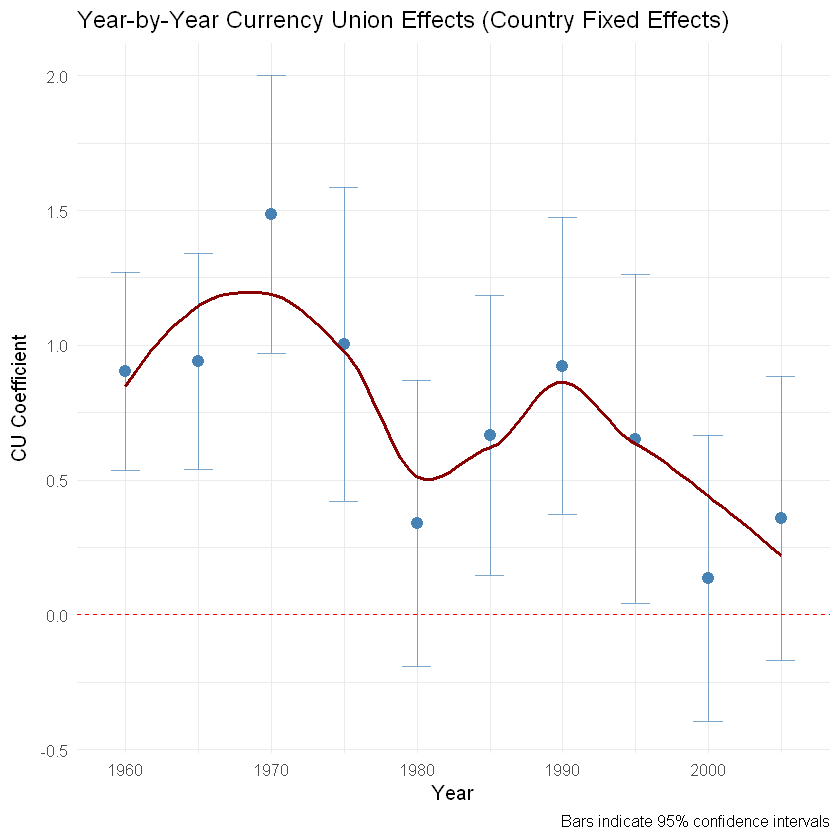

In [5]:
# ============================================================================
# Question h: Year-by-Year Regressions with Country Fixed Effects
# ============================================================================

cat("\n=========== Question h: Year-by-Year Regressions ===========\n")

years <- sort(unique(gravity_clean$year))
yearly_coefficients <- data.frame()

for (yr in years) {
  yearly_data <- gravity_clean %>% filter(year == yr)
  
  if (nrow(yearly_data) > 100) {  # Ensure sufficient observations
    model <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + cu + rta | 
                     iso_o + iso_d, 
                   data = yearly_data)
    
    if ("cu" %in% names(coef(model))) {
      yearly_coefficients <- rbind(yearly_coefficients, 
                                   data.frame(
                                     year = yr,
                                     coef_cu = coef(model)["cu"],
                                     se_cu = se(model)["cu"],
                                     n_obs = nobs(model),
                                     n_countries = n_distinct(c(yearly_data$iso_o, yearly_data$iso_d))
                                   ))
    }
  }
}

print(yearly_coefficients)

# Plot yearly coefficients
p_yearly <- ggplot(yearly_coefficients, aes(x = year, y = coef_cu)) +
  geom_point(size = 3, color = "steelblue") +
  geom_errorbar(aes(ymin = coef_cu - 1.96 * se_cu, 
                    ymax = coef_cu + 1.96 * se_cu), 
                width = 2, color = "steelblue", alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  geom_smooth(method = "loess", se = FALSE, color = "darkred", linewidth = 1) +
  labs(title = "Year-by-Year Currency Union Effects (Country Fixed Effects)",
       y = "CU Coefficient", x = "Year",
       caption = "Bars indicate 95% confidence intervals") +
  theme_minimal(base_size = 12)

print(p_yearly)

In [9]:
# ============================================================================
# Question i(1): Country-Pair Fixed Effects
# ============================================================================

cat("\n=========== Question i(1): Country-Pair Fixed Effects Analysis ===========\n")

# Estimate with country-pair fixed effects
reg_pair_fe <- feols(ln_trade ~ cu + rta + ln_gdp_o + ln_gdp_d | 
                       iso_o + iso_d + iso_o^iso_d + year, 
                     data = gravity_clean, cluster = ~iso_o + iso_d)

cat("\nCountry-pair fixed effects model:\n")
etable(reg_pair_fe)


=========== Question i(1): Country-Pair Fixed Effects Analysis ===========

Country-pair fixed effects model:


,,reg_pair_fe
,<chr>,<chr>
1,Dependent Var.:,ln_trade
2,,
3,cu,0.4460*** (0.1113)
4,rta,0.4021*** (0.0608)
5,ln_gdp_o,1.194*** (0.1091)
6,ln_gdp_d,0.7912*** (0.0918)
7,Fixed-Effects:,------------------
8,iso_o,Yes
9,iso_d,Yes


In [10]:
# (1) Controlling for Time-Varying MRTs
# GDP, Population, and Year dummies are absorbed.
reg_j1 <- feols(ln_trade ~ cu + rta + ln_dist + comlang_off + colony | 
                iso_o^year + iso_d^year, 
                data = gravity_clean, cluster = ~iso_o + iso_d)

# (2) Controlling for MRTs AND Unobserved Pair Heterogeneity
# Distance, Lang, Colony are absorbed by Pair FE.
reg_j2 <- feols(ln_trade ~ cu + rta | 
                iso_o^year + iso_d^year + iso_o^iso_d, 
                data = gravity_clean, cluster = ~iso_o + iso_d)

etable(reg_j1, reg_j2, headers = c("Structural Gravity", "Structural + Pair FE"))

,,reg_j1,reg_j2
,<chr>,<chr>,<chr>
1,,Structural Gravity,Structural + Pair FE
2,Dependent Var.:,ln_trade,ln_trade
3,,,
4,cu,0.4900* (0.1977),0.3495*** (0.1024)
5,rta,0.6660*** (0.1413),0.4011*** (0.0657)
6,ln_dist,-1.361*** (0.0415),
7,comlang_off,0.4328*** (0.0683),
8,colony,1.323*** (0.1117),
9,Fixed-Effects:,------------------,------------------


In [21]:
# ============================================================================
# Question k: Small Countries' Benefits from Currency Unions
# ============================================================================

cat("\n=========== Question k: Small Countries' Benefits ===========\n")

# Define small countries (bottom tercile by average GDP)
median_gdp <- median(pwt$cgdp, na.rm = TRUE)

# Add small country indicators to gravity_clean
gravity_clean <- gravity_clean %>%
  left_join(pwt %>% select(iso3, year, cgdp) %>% 
              mutate(small_o = cgdp < median_gdp),
            by = c("iso_o" = "iso3", "year")) %>%
  left_join(pwt %>% select(iso3, year, cgdp) %>% 
              mutate(small_d = cgdp < median_gdp),
            by = c("iso_d" = "iso3", "year"))

# Create interaction terms
gravity_clean <- gravity_clean %>%
  mutate(
    cu_small_o = cu * small_o,
    cu_small_d = cu * small_d,
    both_small = small_o * small_d,
    cu_both_small = cu * both_small
  )

# Heterogeneity analysis
reg_k1 <- feols(ln_trade ~ cu + small_o + small_d + cu_small_o + cu_small_d + 
                   ln_gdp_o + ln_gdp_d + ln_dist + rta | year,
                 data = gravity_clean, cluster = ~iso_o + iso_d)

reg_k2 <- feols(ln_trade ~ cu + both_small + cu_both_small + 
                   ln_gdp_o + ln_gdp_d + ln_dist + rta | year,
                 data = gravity_clean, cluster = ~iso_o + iso_d)

reg_k3 <- feols(ln_trade ~ cu + both_small + cu_both_small | 
                   iso_o + iso_d + year,
                 data = gravity_clean, cluster = ~iso_o + iso_d)

cat("\nResults suggest:\n")
cat("Interaction coefficients indicate whether small countries benefit more.\n")
cat("Positive interaction = small countries benefit more\n")
cat("Negative interaction = small countries benefit less\n\n")

etable(reg_k1, reg_k2, reg_k3, 
         headers = c("Separate Effects", "Joint Effects", "Country FE"), 
         tex = FALSE)


=========== Question k: Small Countries' Benefits ===========

Results suggest:
Interaction coefficients indicate whether small countries benefit more.
Positive interaction = small countries benefit more
Negative interaction = small countries benefit less



,,reg_k1,reg_k2,reg_k3
,<chr>,<chr>,<chr>,<chr>
1,,Separate Effects,Joint Effects,Country FE
2,Dependent Var.:,ln_trade,ln_trade,ln_trade
3,,,,
4,cu,-0.9088 (0.7351),-0.7887 (0.5776),2.650*** (0.3186)
5,small_oTRUE,0.0880 (0.2289),,
6,small_dTRUE,0.0519 (0.1917),,
7,cu_small_o,0.3791 (0.6877),,
8,cu_small_d,0.1914 (0.6167),,
9,ln_gdp_o,0.7835*** (0.1453),0.7648*** (0.1068),


In [11]:
# ============================================================================
# Question l: Problems with Log-Linearization and Poisson Estimation
# ============================================================================

# PPML Estimation
# Note: Dependent variable is 'trade' (levels), NOT log(trade)
reg_ppml <- fepois(trade ~ cu + rta | 
                   iso_o^year + iso_d^year + iso_o^iso_d, 
                   data = gravity_df %>% mutate(trade = replace_na(trade, 0)), # Keep zeros
                   cluster = ~iso_o + iso_d)

etable(reg_ppml, headers = "PPML")

NOTES: 11,840 observations removed because of NA values (RHS: 11,840).
       245/243/9,544 fixed-effects (142,269 observations) removed because of only 0 outcomes.



,,reg_ppml
,<chr>,<chr>
1,,PPML
2,Dependent Var.:,trade
3,,
4,cu,0.0267 (0.0877)
5,rta,0.1719** (0.0654)
6,Fixed-Effects:,-----------------
7,iso_o-year,Yes
8,iso_d-year,Yes
9,iso_o-iso_d,Yes


In [13]:
# ============================================================================
# Question m: Euro Effect Analysis
# ============================================================================

euro_iso <- c("AUT", "BEL", "DEU", "ESP", "FIN", "FRA", "IRL", "ITA", "LUX", "NLD", "PRT", "GRC")

# Create Euro Dummy
gravity_euro <- gravity_clean %>%
    mutate(
    both_euro = (iso_o %in% euro_iso) & (iso_d %in% euro_iso),
    post_1999 = as.integer(year >= 1999),
    euro_cu = both_euro * post_1999
  )

# Estimate Euro Effect (PPML + Pair FE)
# reg_euro <- fepois(trade ~ euro_cu + rta | 
#                    iso_o^year + iso_d^year + iso_o^iso_d, 
#                    data = gravity_euro,
#                    cluster = ~iso_o + iso_d)

# Estimate Euro effect using different specifications

# Specification 1: Basic difference-in-differences
reg_euro1 <- feols(ln_trade ~ euro_cu + ln_gdp_o + ln_gdp_d + ln_dist + rta + cu | year, 
                   data = gravity_euro, cluster = ~iso_o + iso_d)

# Specification 2: With country fixed effects
reg_euro2 <- feols(ln_trade ~ euro_cu + ln_gdp_o + ln_gdp_d + ln_dist + rta + cu | 
                     iso_o + iso_d + year, 
                   data = gravity_euro, cluster = ~iso_o + iso_d)

# Specification 3: High-dimensional FE (preferred)
reg_euro3 <- feols(ln_trade ~ euro_cu + rta + cu | 
                     iso_o^year + iso_d^year + iso_o^iso_d, 
                   data = gravity_euro, cluster = ~iso_o + iso_d)

# Specification 4: PPML
reg_euro4 <- fepois(trade ~ euro_cu + rta + cu | 
                      iso_o^year + iso_d^year + iso_o^iso_d, 
                    data = gravity_euro %>% mutate(trade = ifelse(is.na(trade), 0, trade)), 
                    cluster = ~iso_o + iso_d)


# 输出
etable(reg_euro1, reg_euro2, reg_euro3, reg_euro4, headers = "Euro Effect (PPML + Pair FE)")

,,reg_euro1,reg_euro2,reg_euro3,reg_euro4
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,Euro Effect (PPML + Pair FE),Euro Effect (PPML + Pair FE),Euro Effect (PPML + Pair FE),Euro Effect (PPML + Pair FE)
2,Dependent Var.:,ln_trade,ln_trade,ln_trade,trade
3,,,,,
4,euro_cu,3.244*** (0.6717),-1.224*** (0.3041),-0.0069 (0.2047),-0.6128*** (0.1374)
5,ln_gdp_o,0.7486*** (0.1054),1.230*** (0.1041),,
6,ln_gdp_d,0.6145*** (0.0981),0.7453*** (0.0990),,
7,ln_dist,-0.7300*** (0.0661),-1.384*** (0.0452),,
8,rta,1.188*** (0.2111),0.6899*** (0.1388),0.4013*** (0.0653),-0.1632 (0.1014)
9,cu,-0.8527* (0.3957),0.9327*** (0.2196),0.3516** (0.1258),0.4832*** (0.1093)


In [ ]:
head(dots, 5)
head(pwt, 5)
head(rta, 5)
head(cu, 5)
head(dist, 5)

In [14]:
save_latex_table <- function(models, model_names, filename, title = NULL, notes = NULL) {
  
  # 使用fixest的etable获取回归结果
  tex_output <- etable(models, 
                      tex = TRUE, 
                      title = title,
                      headers = model_names,
                      style.tex = style.tex("aer"),
                      signif.code = c(`***` = 0.01, `**` = 0.05, `*` = 0.10),
                      digits = 3,
                      digits.stats = 3,
                      fitstat = c("n", "r2", "wr2"),
                      se.row = FALSE,
                      cluster = ~iso_o + iso_d,
                      drop = c("Constant"))
  
  # 将输出写入文件
  sink(filename)
  cat("% Generated by R on", format(Sys.Date(), "%Y-%m-%d"), "\n")
  cat("% Gravity Model Estimation Results\n\n")
  cat("\\begin{table}[htbp]\n")
  cat("\\centering\n")
  
  if (!is.null(title)) {
    cat("\\caption{", title, "}\n", sep = "")
  }
  
  cat("\\label{tab:", gsub("\\.tex$", "", basename(filename)), "}\n")
  cat("\\begin{threeparttable}\n")
  
  # 输出表格内容
  cat(tex_output, "\n")
  
  # 添加注释
  if (!is.null(notes)) {
    cat("\\begin{tablenotes}\n")
    cat("\\small\n")
    cat("\\item ", notes, "\n", sep = "")
    cat("\\item Standard errors clustered by exporter-importer pair in parentheses.\n")
    cat("\\item Significance levels: * p < 0.10, ** p < 0.05, *** p < 0.01.\n")
    cat("\\end{tablenotes}\n")
  }
  
  cat("\\end{threeparttable}\n")
  cat("\\end{table}\n")
  
  sink()
  cat("Table saved to:", filename, "\n")
}

In [15]:
# 保存第一个表格
save_latex_table(
  models = list(reg_a, reg_b, reg_c, reg_e),
  model_names = c("Naive", "+Policy", "+History", "+CountryFE"),
  filename = "table e_basic_gravity.tex",
  title = "Basic Gravity Model Specifications",
  notes = "All specifications include year fixed effects. Columns (1)-(3) are OLS estimates, column (4) includes exporter and importer fixed effects."
)

Table saved to: table e_basic_gravity.tex 


In [23]:
save_latex_table(
  models = list(reg_pair_fe),
  model_names = c("Pair FE"),
  filename = "table i_pair_fe.tex",
  title = "Country-Pair Fixed Effects Analysis",
  notes = "Includes exporter, importer, pair, and year fixed effects to control for unobserved bilateral heterogeneity."
)

Table saved to: table i_pair_fe.tex 


In [16]:
# 保存第二个表格
save_latex_table(
  models = list(reg_j1, reg_j2),
  model_names = c("Structural Gravity", "Structural + Pair FE"),
  filename = "table j_structural_gravity.tex",
  title = "Structural Gravity Model with Multilateral Resistance Terms",
  notes = "Column (1) includes exporter-year and importer-year fixed effects to control for time-varying multilateral resistance terms. Column (2) adds pair fixed effects to control for unobserved time-invariant bilateral heterogeneity."
)

Table saved to: table j_structural_gravity.tex 


In [17]:
# 保存第三个表格
save_latex_table(
  models = list(reg_ppml),
  model_names = c("PPML"),
  filename = "table l_ppml.tex",
  title = "Poisson Pseudo-Maximum Likelihood (PPML) Estimation",
  notes = "PPML estimation including zero trade flows. Includes exporter-year, importer-year, and pair fixed effects."
)

Table saved to: table l_ppml.tex 


In [18]:
# 保存第四个表格
save_latex_table(
    models = list(reg_euro1, reg_euro2, reg_euro3, reg_euro4),
    model_names = c("PPML + Pair FE"),
    filename = "table m_euro_effect.tex",
    title = "PPML EStimation with pair FE for Euro effect",
    notes = "PPML estimation with exporter-year, importer-year, and pair fixed effects. The interaction terms show how the Euro effect evolved over time relative to 1999."
)

Table saved to: table m_euro_effect.tex 


In [22]:
save_latex_table(
    models = list(reg_k1, reg_k2, reg_k3),
    model_names = c("Separate Effects", "Joint Effects", "Country FE"),
    filename = "table k_small_countries.tex",
    title = "Small Countries' Benefits from Currency Unions",
    notes = "Interaction coefficients indicate whether small countries benefit more from currency unions. Positive interaction = small countries benefit more; Negative interaction = small countries benefit less."
)

Table saved to: table k_small_countries.tex 
